In [35]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import numpy as np
import matplotlib.pyplot as plt
from pyfrechet.metric_spaces import MetricData, RiemannianManifold, CorrFrobenius, MetricSpace
from geomstats.geometry.hypersphere import Hypersphere
import pandas as pd
from pyfrechet.metric_spaces.correlation.nearcorr import nearcorr
from tqdm import tqdm
import seaborn as sns
from joblib import Parallel, delayed
from scipy.stats import norm
from scipy import stats
from pyfrechet.metric_spaces import *
import pyfrechet.metric_spaces.wasserstein_1d as W1d

# R with multiplicative noise

In [2]:
def m(x, theta, mu):
    return theta * x + (1-theta)*mu

def sim(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = m(x[i-1], theta, mu) + sig*np.random.randn()
    return x

def sim_mul(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        x[i] = (1 + sig*np.random.randn()) * m(x[i-1], theta, mu)
    return x


def sim_sin(N, theta, sig, mu):
    x = np.zeros(N) + mu
    for i in range(1,N):
        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        z = m(x[i-1], theta, mu)
        x[i] = z - np.sin(np.pi*k*z)/np.pi/k
    return x

In [84]:
M = 1000 # number of replicates
B = 500 # number of bootstrap replicates

phis = np.linspace(0, 1, 6)
Ts = [50, 100, 250, 500, 1000, 1200]


df = pd.DataFrame(columns=['T', 'phi', 'replicate_id', 'err_mu_hat', 'phi_hat', 'Dt', 'boot_mean_Dt', 'boot_sig_Dt'])

mean = 1.5
noise_var = 0.2

def phi_hat(x, mu_hat):
    T = x.shape[0]
    grid = np.linspace(0, 1, 40)
    errs = np.zeros_like(grid)
    for i in range(grid.shape[0]): 
        errs[i] = np.array([ (x[j+1] - m(x[j], grid[i], mu_hat))**2 for j in range(T-1) ]).mean()
    return grid[np.argmin(errs)]

def bootstrap_mu_sig(x, B):
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(x)
        bootstrap[b] = np.mean(np.power(np.diff(permed), 2))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


for T in Ts:
    for phi in phis:
        print(f"Running T={T} phi={phi}")
        for replicate_id in tqdm(range(M)):
            x = sim_mul(T, phi, noise_var, mean)

            mu_hat = x.mean()
            phi_hat_ = phi_hat(x, mu_hat)

            Dt = np.mean(np.power(np.diff(x), 2))

            boot_mean_Dt, boot_sig_Dt = bootstrap_mu_sig(x, B)

            df.loc[len(df)] = [T, phi, replicate_id, (mean - mu_hat)**2, phi_hat_, Dt, boot_mean_Dt, boot_sig_Dt]

df.to_csv('./results_R_mult_noise_extended.csv')

Running T=50 phi=0.0


100%|██████████| 1000/1000 [00:06<00:00, 165.29it/s]


Running T=50 phi=0.2


100%|██████████| 1000/1000 [00:05<00:00, 168.00it/s]


Running T=50 phi=0.4


100%|██████████| 1000/1000 [00:05<00:00, 166.72it/s]


Running T=50 phi=0.6000000000000001


100%|██████████| 1000/1000 [00:06<00:00, 165.15it/s]


Running T=50 phi=0.8


100%|██████████| 1000/1000 [00:06<00:00, 164.23it/s]


Running T=50 phi=1.0


100%|██████████| 1000/1000 [00:06<00:00, 164.27it/s]


In [ ]:
df = pd.read_csv('./results_R_mult_noise_extended.csv')

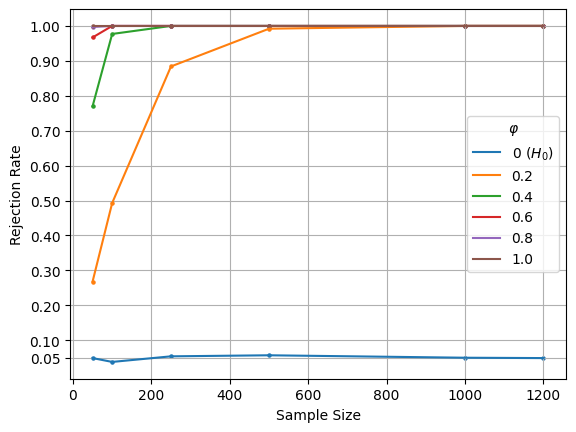

In [4]:
df['rejected'] = (np.abs(df['Dt'] - df['boot_mean_Dt']) / df['boot_sig_Dt']) > norm.ppf(0.975)
results = df.groupby(['T', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

# sns.lineplot(results, x='T', y='rejection_rate', hue='phi')


for phi in results.phi.unique():
    sub_df = results[results['phi'] == phi]

    plt.scatter(sub_df['T'], sub_df.rejection_rate, s=5)
    if phi == 0:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
    else:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=np.round(phi,1))

plt.xlabel('Sample Size')
plt.ylabel('Rejection Rate')
plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);
# plt.xticks(df['T'].unique())

plt.savefig('./rejection_rates_R_mult_noise.pdf')

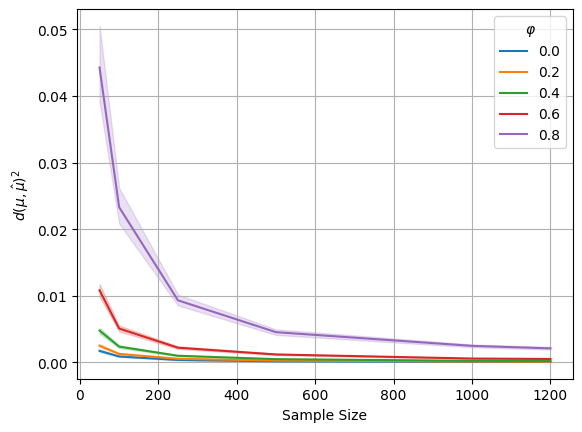

In [33]:
for phi in df.phi.unique():
    if phi == 1:
        continue
    
    sub_df = df[df['phi'] == phi]

#     plt.scatter(sub_df['T'], sub_df., s=5)
    sns.lineplot(sub_df, x='T', y='err_mu_hat', label=np.round(phi,1))

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

plt.savefig('./err_mu_R_mult_noise.pdf')

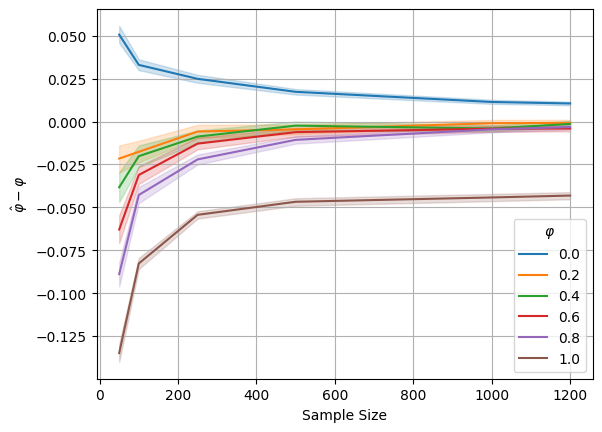

In [34]:
for phi in df.phi.unique():
    sub_df = df[df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = sub_df['phi_hat'] - phi

#     plt.scatter(sub_df['T'], sub_df., s=5)
    sns.lineplot(sub_df, x='T', y='err_phi_hat', label=np.round(phi,1))

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\hat\varphi - \varphi$')

plt.savefig('./err_phi_R_mult_noise.pdf')

100%|██████████| 1000/1000 [00:14<00:00, 70.89it/s]

% rejects under H1 1.0
% rejects under H0 0.062


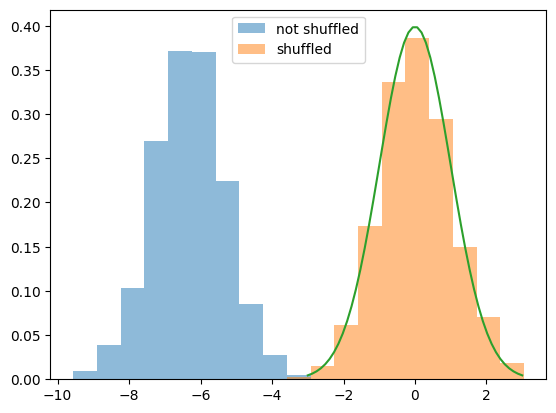

In [9]:
res = np.zeros((1000, 4))

mu = 1.5
theta = 0.2

N = 1_000
B = 500

def bootstrap_mu_sig(x, B):
    # DIRECT ESTIMATION - check this a bit more
    #
    # D_XY_XZ = np.zeros((2, B))
    # for b in range(B):
    #     idx = np.random.randint(N, size=3)
    #     D_XY_XZ[0, b] = np.abs(x[idx[0]] - x[idx[1]])
    #     D_XY_XZ[1, b] = np.abs(x[idx[0]] - x[idx[2]])

    # cov = np.cov(D_XY_XZ)
    # sig_hat = np.sqrt(cov[0,0] + 2*cov[0,1]) / np.sqrt(B)
    # mu_hat = D_XY_XZ[0,:].mean()

    # BOOTSTRAP VERSION
    # 
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(x)
        # bootstrap[b] = np.mean(np.abs(np.diff(permed)))
        bootstrap[b] = np.mean(np.power(np.diff(permed), 2))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat

for i in tqdm(range(res.shape[0])):
    x = sim_mul(N, theta, 0.13, mu)
    
    # res[i,0] = np.mean(np.abs(np.diff(x)))
    res[i,0] = np.mean(np.power(np.diff(x), 2))

    permed = np.random.permutation(x)
    # res[i,1] =  np.mean(np.abs(np.diff(permed)))
    res[i,1] = np.mean(np.power(np.diff(permed), 2))

    mu_hat, sig_hat = bootstrap_mu_sig(x, B)
    res[i, 2] = mu_hat
    res[i, 3] = sig_hat

plt.hist((res[:, 0] - res[:, 2]) / res[:, 3], label='not shuffled', alpha=0.5, density=True)
plt.hist((res[:, 1] - res[:, 2]) / res[:, 3], label='shuffled', alpha=0.5, density=True)

_x = np.linspace(-3, 3)
plt.plot(_x, norm.pdf(_x))

print("% rejects under H1", (np.abs((res[:, 0] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())
print("% rejects under H0", (np.abs((res[:, 1] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())

plt.legend()


# Wasserstein

In [39]:
def gamma(x, theta, mu):
    # the rvs are represented as their quantile functions, so interpolation is euclidean
    return theta * x + (1-theta)*mu

def sim(N, theta, mu):
    x = np.zeros((N, mu.shape[0])) + mu
    for i in range(1,N):
        z = gamma(x[i-1], theta, mu)

        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        x[i, :] = z - np.sin(np.pi*k*z)/np.pi/abs(k)
    return x

# M = 1000 # number of replicates
M = 100
B = 500 # number of bootstrap replicates

phis = np.linspace(0, 1, 6)
# Ts = [50, 100, 250, 500, 1000, 1200]
Ts = [100, 500, 1000]

df = pd.DataFrame(columns=['T', 'phi', 'replicate_id', 'err_mu_hat', 'phi_hat', 'Dt', 'boot_mean_Dt', 'boot_sig_Dt'])

STD_NORMAL_Q = stats.norm.ppf(W1d.Wasserstein1D.GRID)
STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs
mean = STD_NORMAL_Q

def phi_hat(x, mu_hat):
    T = x.shape[0]
    W = W1d.Wasserstein1D()

    grid = np.linspace(0, 1, 40)

    def calc(phi): return np.array([ W._d(x[j+1,:], gamma(x[j,:], phi, mu_hat))**2 for j in range(T-1) ]).mean()
    errs = np.array([ calc(phi) for phi in grid ])
    
    return grid[np.argmin(errs)]

def bootstrap_mu_sig(x, B):
    bootstrap = np.zeros(B)
    for b in range(B):
        permed = np.random.permutation(np.arange(x.shape[0]))
        bootstrap[b] = np.array([ W._d(x[permed[j],:], x[permed[j+1],:])**2 for j in range(T-1) ]).mean()
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


for T in Ts:
    for phi in phis:
        print(f"Running T={T} phi={phi}")
        for replicate_id in tqdm(range(M)):
            x = sim(T, phi, mean)

            W = W1d.Wasserstein1D()
            mu_hat = MetricData(W, x).frechet_mean()

            phi_hat_ = phi_hat(x, mu_hat)

            Dt = np.array([ W._d(x[j,:], x[j+1,:])**2 for j in range(T-1) ]).mean()
            
            boot_mean_Dt, boot_sig_Dt = bootstrap_mu_sig(x, B)

            df.loc[len(df)] = [T, phi, replicate_id, W._d(mean, mu_hat)**2, phi_hat_, Dt, boot_mean_Dt, boot_sig_Dt]

df.to_csv('./results_wasserstein.csv')

Running T=100 phi=0.0


100%|██████████| 100/100 [00:48<00:00,  2.05it/s]


Running T=100 phi=0.2


100%|██████████| 100/100 [00:47<00:00,  2.10it/s]


Running T=100 phi=0.4


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Running T=100 phi=0.6000000000000001


100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


Running T=100 phi=0.8


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Running T=100 phi=1.0


100%|██████████| 100/100 [00:48<00:00,  2.07it/s]


Running T=500 phi=0.0


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Running T=500 phi=0.2


100%|██████████| 100/100 [03:07<00:00,  1.88s/it]


Running T=500 phi=0.4


100%|██████████| 100/100 [03:11<00:00,  1.92s/it]


Running T=500 phi=0.6000000000000001


100%|██████████| 100/100 [03:13<00:00,  1.93s/it]


Running T=500 phi=0.8


100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


Running T=500 phi=1.0


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Running T=1000 phi=0.0


100%|██████████| 100/100 [06:03<00:00,  3.63s/it]


Running T=1000 phi=0.2


100%|██████████| 100/100 [06:03<00:00,  3.64s/it]


Running T=1000 phi=0.4


100%|██████████| 100/100 [06:05<00:00,  3.66s/it]


Running T=1000 phi=0.6000000000000001


100%|██████████| 100/100 [06:12<00:00,  3.73s/it]


Running T=1000 phi=0.8


100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


Running T=1000 phi=1.0


100%|██████████| 100/100 [06:05<00:00,  3.65s/it]


In [40]:
df

,T,phi,replicate_id,err_mu_hat,phi_hat,Dt,boot_mean_Dt,boot_sig_Dt
0,100.0,0.0,0.0,0.010938,0.025641,0.038176,0.039391,0.003018
1,100.0,0.0,1.0,0.003006,0.025641,0.037532,0.038301,0.002840
2,100.0,0.0,2.0,0.024224,0.076923,0.032958,0.035891,0.002692
3,100.0,0.0,3.0,0.012177,0.128205,0.033538,0.039124,0.002861
4,100.0,0.0,4.0,0.017714,0.000000,0.041362,0.041700,0.003068
...,...,...,...,...,...,...,...,...
1795,1000.0,1.0,95.0,0.535676,0.692308,0.000169,0.001546,0.000036
1796,1000.0,1.0,96.0,0.364725,0.717949,0.000163,0.001033,0.000019
1797,1000.0,1.0,97.0,0.541709,0.871795,0.000217,0.003672,0.000103
1798,1000.0,1.0,98.0,0.446584,0.743590,0.000125,0.001220,0.000036


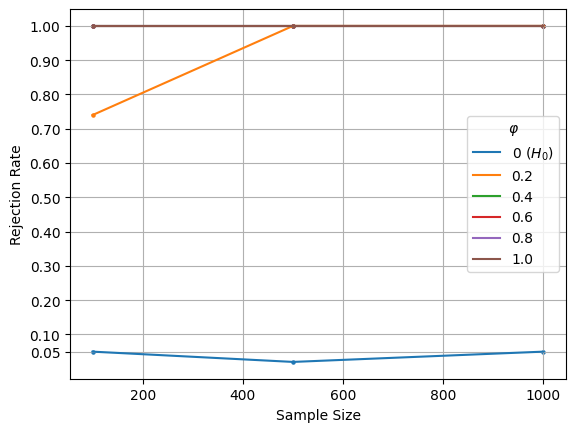

In [41]:
df['rejected'] = (np.abs(df['Dt'] - df['boot_mean_Dt']) / df['boot_sig_Dt']) > norm.ppf(0.975)
results = df.groupby(['T', 'phi']).agg(rejection_rate=('rejected', 'mean')).reset_index()

# sns.lineplot(results, x='T', y='rejection_rate', hue='phi')


for phi in results.phi.unique():
    sub_df = results[results['phi'] == phi]

    plt.scatter(sub_df['T'], sub_df.rejection_rate, s=5)
    if phi == 0:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=r'$0\ (H_0)$')
    else:
        plt.plot(sub_df['T'], sub_df.rejection_rate, label=np.round(phi,1))

plt.xlabel('Sample Size')
plt.ylabel('Rejection Rate')
plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.yticks([0.05,0.1,0.2,0.3,0.4,0.5,0.6,.7,.8,.9,1]);
# plt.xticks(df['T'].unique())

plt.savefig('./rejection_rates_wasserstein.pdf')

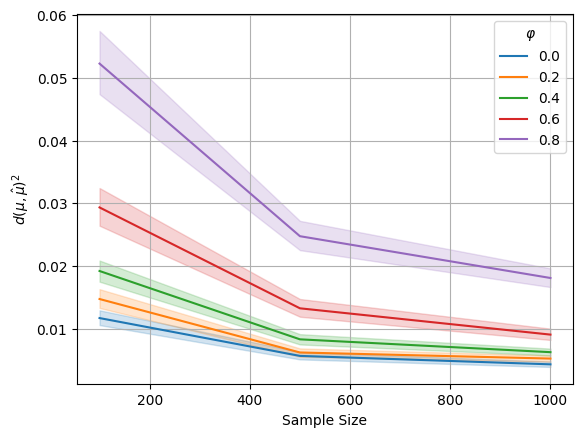

In [45]:
for phi in df.phi.unique():
    if phi == 1:
        continue
    
    sub_df = df[df['phi'] == phi]

#     plt.scatter(sub_df['T'], sub_df., s=5)
    sns.lineplot(sub_df, x='T', y='err_mu_hat', label=np.round(phi,1))

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$d(\mu, \hat\mu)^2$')

plt.savefig('./err_mu_wasserstein.pdf')

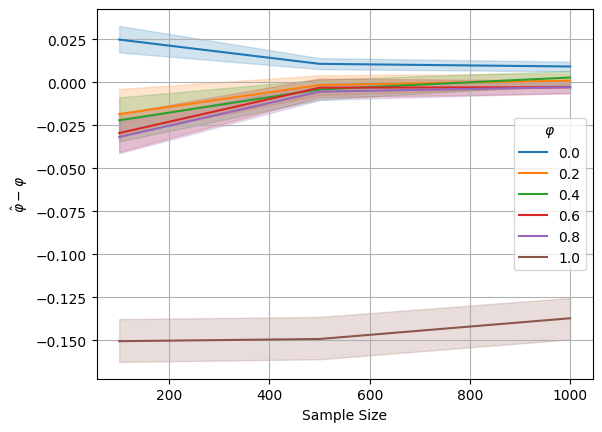

In [43]:
for phi in df.phi.unique():
    sub_df = df[df['phi'] == phi].copy()
    sub_df['err_phi_hat'] = sub_df['phi_hat'] - phi

#     plt.scatter(sub_df['T'], sub_df., s=5)
    sns.lineplot(sub_df, x='T', y='err_phi_hat', label=np.round(phi,1))

plt.legend(title=r'$\varphi$')
plt.grid('on')
plt.xlabel('Sample Size')
plt.ylabel(r'$\hat\varphi - \varphi$')

plt.savefig('./err_phi_wasserstein.pdf')

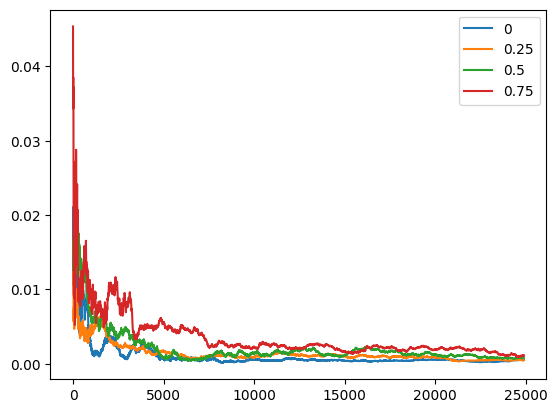

In [316]:


def gamma(x, theta, mu):
    # the rvs are represented as their quantile functions, so interpolation is euclidean
    return theta * x + (1-theta)*mu

def sim(N, theta, mu):
    x = np.zeros((N, mu.shape[0])) + mu
    for i in range(1,N):
        z = gamma(x[i-1], theta, mu)

        k = (1 - 2*np.random.binomial(1,0.5)) * np.random.random_integers(1, 4)
        x[i, :] = z - np.sin(np.pi*k*z)/np.pi/abs(k)
    return x

STD_NORMAL_Q = stats.norm.ppf(W1d.Wasserstein1D.GRID)
STD_NORMAL_Q[0] = 2*STD_NORMAL_Q[1] - STD_NORMAL_Q[2] # lexp to avoid infs
STD_NORMAL_Q[-1] = 2*STD_NORMAL_Q[-2] - STD_NORMAL_Q[-3] # lexp to avoid infs


N = 25_000
thetas = [0, 0.25, 0.5, 0.75]
mu = STD_NORMAL_Q

for j in range(len(thetas)):
    theta = thetas[j]
    x = sim(N, theta, mu)

    M = W1d.Wasserstein1D()

    mu_hats = np.zeros_like(x)
    errs = np.zeros(N)
    for i in range(2,N):
        mu_hats[i,:] = MetricData(M, x[:i,:]).frechet_mean()
        errs[i] = M.d(mu, mu_hats[i,:])

    plt.plot(errs[100:], label=theta)

plt.legend()


100%|██████████| 100/100 [00:01<00:00, 52.22it/s]


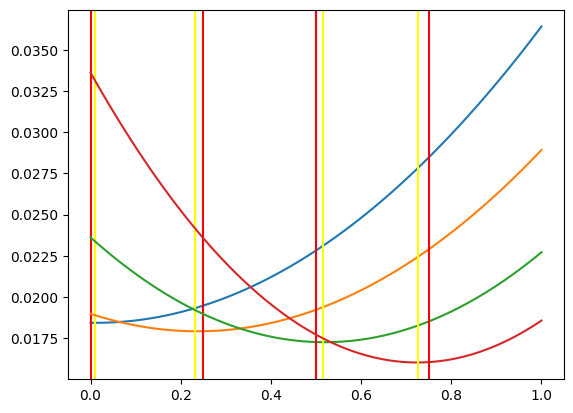

In [318]:
tgrid = np.linspace(0,1,100)

N = 1_000
thetas = [0, 0.25, 0.5, 0.75]
mu = STD_NORMAL_Q

for j in range(len(thetas)):
    theta = thetas[j]
    x = sim(N, theta, mu)

    M = W1d.Wasserstein1D()
    mu_hat = MetricData(M, x).frechet_mean()
    def calc(_theta): return np.array([ M._d(gamma(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()

    errs = np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])
    plt.plot(tgrid, errs, label=theta)
    plt.axvline(theta, color='red', label=theta)
    plt.axvline(tgrid[np.argmin(errs)], color='yellow', label=theta)



# tgrid = np.linspace(0,1,100)
# def calc(_theta): return np.array([ M._d(gamma(x[j-1,:], _theta, mu_hat), x[j,:])**2 for j in range(1, N) ]).mean()
# errs = np.array([ calc(tgrid[i]) for i in tqdm(range(tgrid.shape[0])) ])

# plt.plot(tgrid, errs)
# plt.axvline(theta, color='red')
# plt.axvline(tgrid[np.argmin(errs)], color='yellow')

100%|██████████| 1000/1000 [17:39<00:00,  1.06s/it]

% rejects under H1 1.0
% rejects under H0 0.054


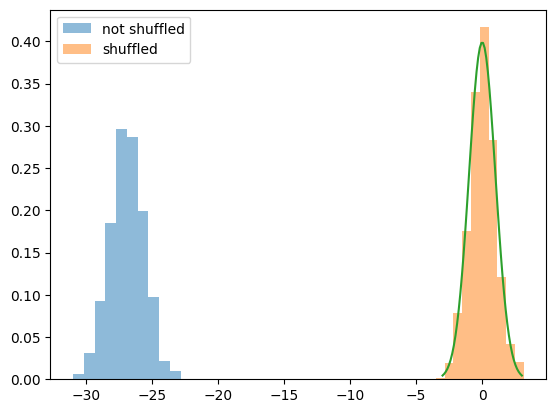

In [303]:
def Dn(x):
    # faster to do by hand to get vectorization
    return np.sqrt(np.sum(np.power(np.diff(x, axis=0), 2), axis=1)).mean() * np.sqrt(W1d.Wasserstein1D.GRID[1] - W1d.Wasserstein1D.GRID[0])

def bootstrap_mu_sig(x, B):
    # DIRECT ESTIMATION - check this a bit more
    #
    # D_XY_XZ = np.zeros((2, B))
    # for b in range(B):
    #     idx = np.random.randint(N, size=3)
    #     D_XY_XZ[0, b] = np.abs(x[idx[0]] - x[idx[1]])
    #     D_XY_XZ[1, b] = np.abs(x[idx[0]] - x[idx[2]])

    # cov = np.cov(D_XY_XZ)
    # sig_hat = np.sqrt(cov[0,0] + 2*cov[0,1]) / np.sqrt(B)
    # mu_hat = D_XY_XZ[0,:].mean()

    # BOOTSTRAP VERSION
    # 

    # def boot():
    #     return Dn(np.random.permutation(x))

    # bootstrap = np.array(Parallel(n_jobs=-1)(delayed(boot)() for i in range(B)))

    bootstrap = np.zeros(B)
    for b in range(B):
        bootstrap[b] = Dn(np.random.permutation(x))
    
    sig_hat = np.sqrt(bootstrap.var())
    mu_hat = bootstrap.mean()
    
    return mu_hat, sig_hat


res = np.zeros((1000, 4))

N = 1_000
B = 1_000

theta = 0.5
mu = STD_NORMAL_Q

for i in tqdm(range(res.shape[0])):
    x = sim(N, theta, mu)
    
    res[i,0] = Dn(x)

    permed = np.random.permutation(x)
    res[i,1] = Dn(permed)

    mu_hat, sig_hat = bootstrap_mu_sig(x, B)
    res[i, 2] = mu_hat
    res[i, 3] = sig_hat

plt.hist((res[:, 0] - res[:, 2]) / res[:, 3], label='not shuffled', alpha=0.5, density=True)
plt.hist((res[:, 1] - res[:, 2]) / res[:, 3], label='shuffled', alpha=0.5, density=True)

_x = np.linspace(-3, 3)
plt.plot(_x, norm.pdf(_x))

print("% rejects under H1", (np.abs((res[:, 0] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())
print("% rejects under H0", (np.abs((res[:, 1] - res[:, 2]) / res[:, 3]) > norm.ppf(0.975)).mean())

plt.legend()

